In [1]:
# test classification dataset
from sklearn.datasets import make_classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, recall_score
import RIfunctions as ri
from sklearn.impute import SimpleImputer
import joblib
import seaborn as sns

In [2]:
data = pd.read_csv('input_file_2.csv', sep = ',', index_col=0)

In [3]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [4]:
data = data.loc[data['issue_d'] < '2016-1-1']
data = data.drop(data[data['purpose'] == 'educational'].index)

<AxesSubplot:>

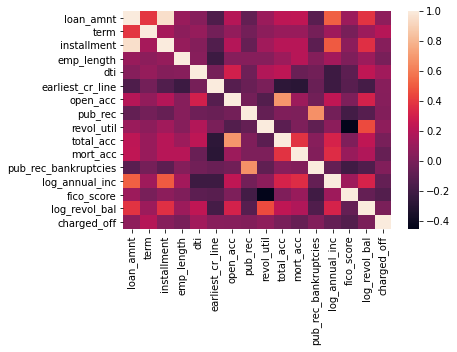

In [5]:
corr = data.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [6]:
all_cols = list(data.columns)
all_cols.remove("charged_off")
all_cols.remove('issue_d')

to_drop_categorical = ['home_ownership', 'verification_status', 'purpose', 'application_type']
all_cols = [e for e in all_cols if e not in to_drop_categorical]

print('to scale     ', all_cols)

to scale      ['loan_amnt', 'term', 'installment', 'emp_length', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score', 'log_revol_bal']


In [7]:
# numerical_cols = ['loan_amnt', 'emp_length', 'dti']

# data = data[['loan_amnt', 'emp_length', 'dti','purpose','charged_off']]

# all_cols = list(data.columns)
# all_cols.remove("charged_off")

In [8]:
data = pd.get_dummies(data,prefix=["hom","ver","purp","app"], columns=to_drop_categorical, drop_first=False)
# data = pd.get_dummies(data, prefix=["purp"], columns=['purpose'], drop_first=False)

In [9]:
# Training the GB model on the full dataset

# train_df = data.loc[data['issue_d'] < data['issue_d'].quantile(0.80)]
# test_df = data.loc[data['issue_d'] >= data['issue_d'].quantile(0.80)]

In [10]:
data.drop('issue_d', axis=1, inplace=True)
# test_df.drop('issue_d', axis=1, inplace=True)

In [11]:
data.isna().sum()

loan_amnt                      0
term                           0
installment                    0
emp_length                 31490
dti                            0
earliest_cr_line               0
open_acc                       0
pub_rec                        0
revol_util                   368
total_acc                      0
mort_acc                   46857
pub_rec_bankruptcies         676
log_annual_inc                 0
fico_score                     0
log_revol_bal                  0
charged_off                    0
hom_MORTGAGE                   0
hom_OWN                        0
hom_RENT                       0
ver_Not Verified               0
ver_Source Verified            0
ver_Verified                   0
purp_car                       0
purp_credit_card               0
purp_debt_consolidation        0
purp_home_improvement          0
purp_house                     0
purp_major_purchase            0
purp_medical                   0
purp_moving                    0
purp_other

In [13]:
# Similar to SimpleImputer 

impute = SimpleImputer(copy=False)
df = pd.DataFrame(impute.fit_transform(data))
df.columns = data.columns
df.index = data.index

# # train_df['emp_length'].fillna(train_df['emp_length'].mean(), inplace = True)
# # test_df['emp_length'].fillna(test_df['emp_length'].mean(), inplace=True)

# data[all_cols] = data[all_cols].fillna(data[all_cols].mean())
# # test_df[all_cols] = test_df[all_cols].fillna(train_df[all_cols].mean())
print('null values      ', df.isnull().sum())

KeyboardInterrupt: 

In [ ]:
scaler = StandardScaler(copy=False)

df[all_cols] = scaler.fit_transform(df[all_cols], df['charged_off'])
# test_df[all_cols] = scaler.transform(test_df[all_cols])

print(scaler.mean_)

[1.42506480e+04 5.95671027e+00 1.76800972e+01]


In [ ]:
train_df_y = df['charged_off']
train_df_x = df.drop('charged_off', axis=1)

# test_df_x = test_df.drop('charged_off', axis=1)
# test_df_y = test_df['charged_off']

In [ ]:
model = joblib.load("./random_forest.joblib")

In [ ]:
model_2 = BalancedRandomForestClassifier(**model.get_params())
model_2.set_params(max_depth=12)
print(model_2.get_params())
model_2.fit(train_df_x, train_df_y)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(criterion='entropy', max_depth=12,
                               max_features='log2', random_state=42)

In [ ]:
# 10 fold cross roc_auc
cv_scores_train = cross_val_score(estimator= model_2, X=train_df_x, y=train_df_y, scoring='roc_auc', cv=10, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train), std(cv_scores_train)))

# cv_scores_test = cross_val_score(estimator= model_2, X=test_df_x, y=test_df_y, scoring='roc_auc', cv=10, n_jobs=-1)
# print("(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test), std(cv_scores_test)))

(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.613 (0.020)


In [ ]:
yhat = model_2.predict(train_df_x)
print(roc_auc_score(train_df_y, yhat), recall_score(train_df_y, yhat, pos_label=1), recall_score(train_df_y, yhat, pos_label=0))

0.5989932351089224 0.5909355026147589 0.607050967603086


In [ ]:
yhat_prob = model_2.predict_proba(train_df_x)

**Extrapolation (Hard-Cut Off)**

In [ ]:
application_df = pd.read_csv('input_file_1.csv', sep = ',', index_col=0)

C:\Users\joshy\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
application_df['issue_d'] = pd.to_datetime(application_df['issue_d'])
application_df = application_df.loc[application_df['issue_d'] < '2016-1-1']
application_df = ri.purposeCleaning(application_df)
application_df = application_df.drop(application_df[application_df['purpose'] == 'Business'].index)
application_df = pd.get_dummies(application_df, prefix=["purp"], columns=['purpose'], drop_first=False)
application_df['purp_renewable_energy'] = 0
application_df.drop('issue_d', axis=1, inplace=True)

In [ ]:
application_df.isna().sum()

dti                             0
emp_length                 133138
loan_amnt                       0
rejected                        0
purp_car                        0
purp_credit_card                0
purp_debt_consolidation         0
purp_home_improvement           0
purp_house                      0
purp_major_purchase             0
purp_medical                    0
purp_moving                     0
purp_other                      0
purp_small_business             0
purp_vacation                   0
purp_wedding                    0
purp_renewable_energy           0
dtype: int64

In [ ]:
iapplication_df = pd.DataFrame(impute.transform(application_df))
iapplication_df.columns = application_df.columns
iapplication_df.index = application_df.index

c:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- rejected
Feature names seen at fit time, yet now missing:
- charged_off

  warnings.warn(message, FutureWarning)


In [ ]:
numerical_cols = ["dti", "emp_length", "loan_amnt"]
iapplication_df[numerical_cols] = scaler.transform(iapplication_df[numerical_cols])

c:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
rejects = iapplication_df.loc[iapplication_df["rejected"] ==1]

In [ ]:
rejects.isna().sum()

dti                        0
emp_length                 0
loan_amnt                  0
rejected                   0
purp_car                   0
purp_credit_card           0
purp_debt_consolidation    0
purp_home_improvement      0
purp_house                 0
purp_major_purchase        0
purp_medical               0
purp_moving                0
purp_other                 0
purp_small_business        0
purp_vacation              0
purp_wedding               0
purp_renewable_energy      0
dtype: int64

In [ ]:
rejects.drop('rejected', axis=1, inplace=True)

c:\Users\joshy\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
reject_bad_prob = model_2.predict_proba(rejects)

c:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
(reject_bad_prob[:,1])

array([0.52919414, 0.53273484, 0.62287984, ..., 0.48402921, 0.53273484,
       0.49738652])